# Low Rank Data + Sparsity = weirdness

In this notebook I go over a demonstration of an odd effect of regularization on low rank data with regards to the bias-variance tradeoff. 

All simulations are done in R because why not.

In [1]:
# Necessary libraries
library(glmnet)
library(tidyverse)
library(ggplot2)
library(matrixStats)
library(clusterGeneration)
library(denoiseR)
library(gplots)
library(RColorBrewer)

set.seed(121)

Loading required package: Matrix

Loaded glmnet 3.0-2


── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  2.1.3     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count


Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess




## 1. Generate low rank data

For this we will use the _LRsim_ function in the _denoiseR_ package. 

Let's define our terms first.

* $n$ = number of observations (rows)

* $p$ = number of features (columns)

* $k$ = rank of data 

* $s$ = signal-to-noise ratio


Now we want to be able to generate an $nxp$ dataset $\bf{X}$, with rank $k$, that associates with the $nx1$ outcome variable $\bf{Y}$. Here $\bf{X}$ is mutlivariate normal $N(0,\sigma)$, with $s=\frac{1}{\sigma \sqrt(np)}$.

When I say "rank" I mean the number of non-zero singular values in an singular value decomposition (SVD) of $X$, i.e., the $k$ is the number of non-zero diagonal elements in $\Sigma$ in the singular SVD $X=U\Sigma V^{*}$.


What we will do is weight the lower dimensional components of $\bf{X}$ according to their loading (i.e., the components that explain the most variance have the most influence on $\bf{Y}$. 

Basically, this is setting up a principal component regression model.



In [2]:
make_data <- function(n,p,k,s){
  
  if (n < p){
    # If number of features is greater 
    # than number of observations, increase
    # observations for the PCA to work
    m=p
  } else {
    # Otheriwse use the input n
    m=n
  }
  
  if (p < k) {
    # Make full rank until p=k
    # degree_diff = k-p
    x = LRsim(m,p,p,s)$X
  } else {
    x = LRsim(m,p,k,s)$X
  }

  # Recover low-d components
  z = princomp(x)
  
  # Version A: Give greatest influence to strongest components
  u = sort(seq(0,1,by=1/(p-1)),decreasing=TRUE)
  
  # Version B: Assign influence randomly
  #u = runif(p)
  
  # Version C: Set the first k components to ~1, otherwise 0
  # if (p-k < 0){
  #   u = rnorm(p,mean=1,sd=0.5)
  # } else {
  #   u = c(rnorm(k,mean=1,sd=0.5),matrix(0,nrow=1,ncol=p-k))
  # }
  # 
  # Calculate the weights in the data space
  b = t(u %*% t(z$loadings))
  
  # In case we needed to set m=p for the 
  # PCA to work, take the first n observations
  # of x
  x = x[1:n,]
  
  # Generate your output
  y = x %*% b #+ rnorm(n, sd = 0.05)
  
  return(list(X=x, Y=y, B=b))
}

Some things to note about this function. 

1. It generates $p>k$ and $p>n$ data. Whenever $p<k$, the matrix is full rank. 
2. $b$ are the coefficients in data space ($\bf{X}$), whereas $u$ are the coefficients in the lower dimensional component space ($\bf{Z}$). Here $\bf{Z} = \phi \bf{X}$, where $\phi$ is the PCA loading matrix.

Let's take a look at this data.

In [3]:
n = 80
p = 20
k = 5
s = 10
data = make_data(n,p,k,s)
summary(lm(Y~X, data=data))

Warning message in summary.lm(lm(Y ~ X, data = data)):
“essentially perfect fit: summary may be unreliable”



Call:
lm(formula = Y ~ X, data = data)

Residuals:
       Min         1Q     Median         3Q        Max 
-1.297e-16 -1.078e-17  2.635e-18  1.263e-17  5.261e-17 

Coefficients:
              Estimate Std. Error    t value Pr(>|t|)    
(Intercept) -7.758e-19  3.180e-18 -2.440e-01    0.808    
X1           1.838e+00  1.244e-15  1.478e+15   <2e-16 ***
X2          -3.044e-02  1.255e-15 -2.426e+13   <2e-16 ***
X3           3.730e-01  1.392e-15  2.680e+14   <2e-16 ***
X4          -7.314e-02  1.058e-15 -6.913e+13   <2e-16 ***
X5           6.719e-01  1.230e-15  5.461e+14   <2e-16 ***
X6          -2.119e-01  1.166e-15 -1.818e+14   <2e-16 ***
X7          -4.179e-01  1.159e-15 -3.606e+14   <2e-16 ***
X8           3.981e-01  1.026e-15  3.878e+14   <2e-16 ***
X9          -2.315e-01  1.089e-15 -2.125e+14   <2e-16 ***
X10         -8.257e-02  1.318e-15 -6.263e+13   <2e-16 ***
X11         -5.425e-01  1.285e-15 -4.222e+14   <2e-16 ***
X12          2.841e-02  1.121e-15  2.534e+13   <2e-16 ***
X13      

Even though $k=5$ all of the $p=20$ features are "statistically" significant. This is okay since the real complexity of the model is determined in the lower dimensional component space $\bf{Z}$. 

Think of this by analogy. The visual world is low rank (i.e., the number of objects in the visual environment at any time is much smaller than the number of cells in the retina), however, the responses of every cell in the retina are meaningful with regards to that low rank world. Basically all of our sensors are relevant for picking up on the lower dimensional compleixty of our little simulated world.


Now we can visualize the correlational structure of our data set. Here we'll use single-linkage clustering for illustrative purposes.

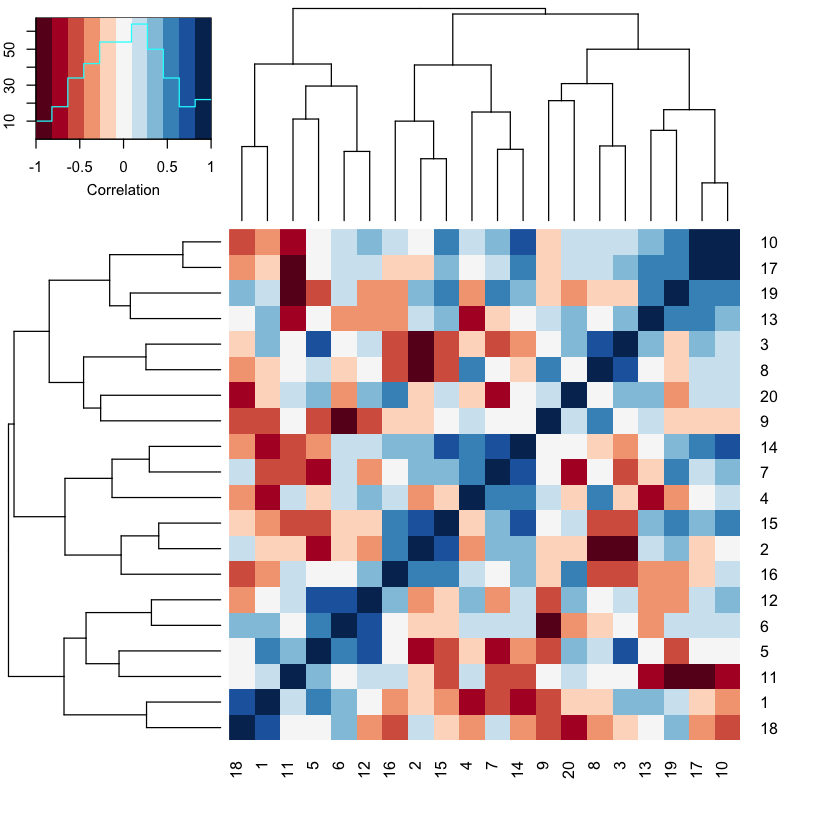

In [4]:
heatmap.2(cor(data$X),col=brewer.pal(11,"RdBu"), trace="none", 
          key.title = NA, key.ylab = NA, key.xlab = "Correlation")

# 2. The bias-variance tradeoff without regularization

Now the classical understanding $\bf{Y} = \hat{f}(\bf{X})$ is that $n=p$ is the upper limit of model interpetability. In other words, there is a unique solution and the complexity (dimensionality) of that solution is $<k$. 

So let's test this idea using ridge regression without sparsity.


In [5]:
## ------------------------------
# GLM split validation function
## ------------------------------
bv_glm <- function(n, degree, k, s, lambda) {
    # Set up the arrays for storing the results
    train_rss = matrix(data=NA,nrow=degree,ncol=1)
    test_rss = matrix(data=NA,nrow=degree,ncol=1)

    # Loop through for each set of p-features
    for (p in degree) {
        # Set up the data, split into training and test
        # sets of size n
        data = make_data(n*2,p,k,s)
        train = list(X=data$X[1:n,],Y = data$Y[1:n])
        test = list(X=data$X[(n+1):nrow(data$X),],Y = data$Y[(n+1):nrow(data$X)])

        # Use simple GLM
        glm = lm(Y ~ X, data=train) #, subset=set_id)
    
        # Get your model prediction on both the training
        # and test sets
        yhat_train = predict(glm)
        yhat_test  = predict(glm, newdata=test)

        # Because we get weird outlier predictions plot median sum square error
        train_rss[p-degree[1]+1] = median((train$Y - yhat_train)^2)
        test_rss[p-degree[1]+1] = median((test$Y - yhat_test)^2)
    }
  
    # Store the RSS in a data frame
    out = data.frame(p=degree, train=train_rss, test=test_rss)
}

Here is what a run looks like.

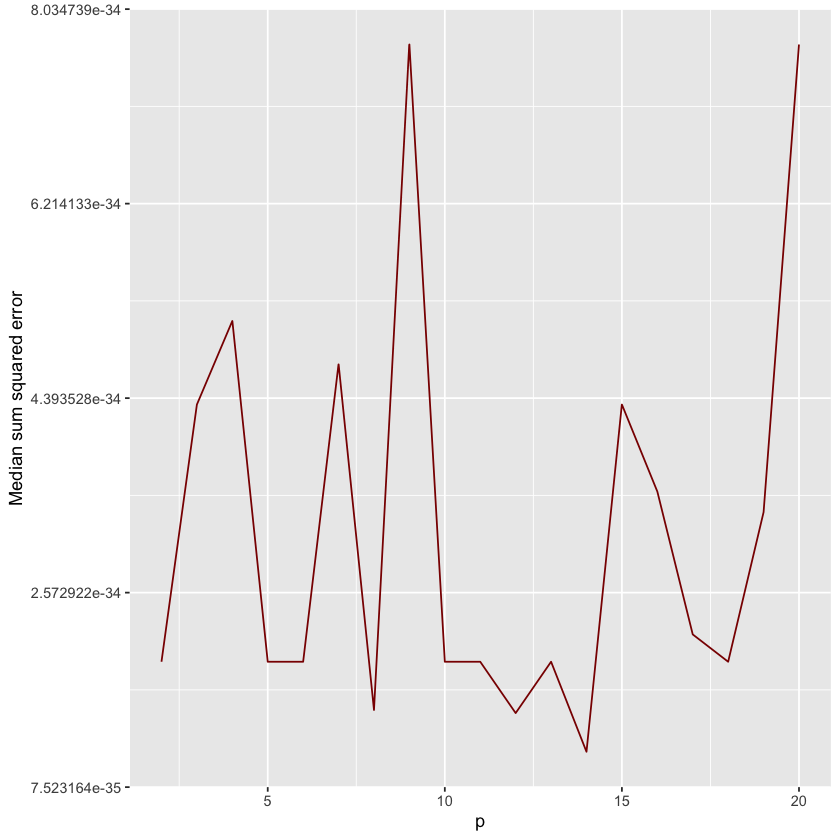

In [6]:
n = 80
k = 20 
s = 10
lambda = .0000001
degree = seq(2,20)

bv_df = bv_glm(n,degree,k, s)

ggplot(bv_df, aes(x=p)) +
  geom_line(aes(y = test), color = "darkred") +
  ylab("Median sum squared error") + xlab("p")


Not much there, but you notice that the test error skyrockets as $p$ gets larger. If you squint, somewhere around $p<5$ the test error is minimized.

But to get a clearer look, let's run a few sims and average together.

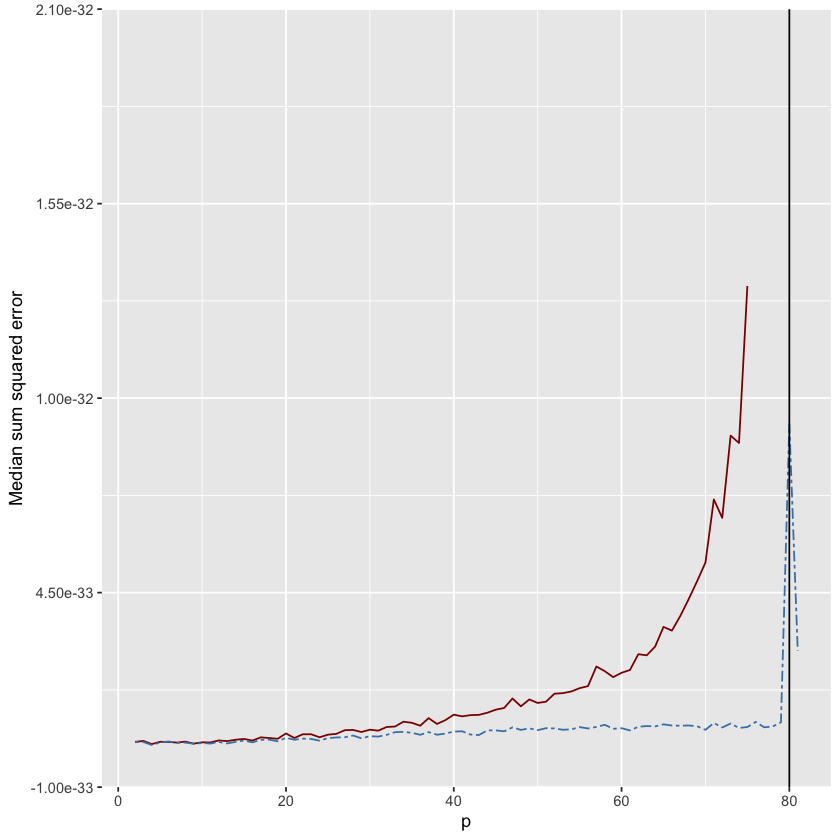

In [7]:
options(warn=-1)

# Parameters
n_iter = 50
n = 80
k = 20 
s = 10
degree = seq(2,81)

# Aggregated output
train_rss = matrix(data=NA,nrow=length(degree),ncol=n_iter)
test_rss = matrix(data=NA,nrow=length(degree),ncol=n_iter)

# Loop through n_iter times
for (i in 1:n_iter) {
  bv_df = bv_glm(n,degree,k,s)
  train_rss[,i]=bv_df$train
  test_rss[,i] =bv_df$test
}

# Make a new data frame for plotting
run_df = data.frame(p=degree, train=rowMeans(train_rss), test=rowMeans(test_rss),
                    strain=rowSds(train_rss), stest=rowSds(test_rss))

# Plot
ggplot(run_df, aes(x=p)) +
  geom_line(aes(y = test), color = "darkred") +
  geom_line(aes(y = train), color="steelblue", linetype="twodash") +
  geom_vline(xintercept = n, color = "black", size=0.5) +
  #geom_ribbon(aes(ymin=test-(stest/sqrt(n))*1.96, ymax=test+(stest/sqrt(n))*1.96), fill="red", alpha=0.2) +
  ylab("Median sum squared error") + xlab("p") + ylim(0,2e-32)


So here we see the class effect of overparameterization. As $p$ increases, the test error (red) increases beyond the training error (blue dashed). So the optimal model is when $p$ is really small. Somewhere around 5 or 6 based on a visual inspection of the results above.

# 3. The bias-variance trade off with regularization

Let's make the same function, but now with ridge regression

In [8]:
## ------------------------------
# Ridge regression split validation function
## ------------------------------
bv_ridge <- function(n, degree, k, s, lambda) {
    # Set up the arrays for storing the results
    train_rss = matrix(data=NA,nrow=degree,ncol=1)
    test_rss = matrix(data=NA,nrow=degree,ncol=1)

    # Loop through for each set of p-features
    for (p in degree) {
        # Set up the data, split into training and test
        # sets of size n
        data = make_data(n*2,p,k,s)
        train = list(X=data$X[1:n,],Y = data$Y[1:n])
        test = list(X=data$X[(n+1):nrow(data$X),],Y = data$Y[(n+1):nrow(data$X)])

        # Use ridge regression on the training set
        ridge.glm = glmnet(train$X, train$Y, alpha=0, lambda=lambda)

        # Get your model prediction on both the training
        # and test sets
        yhat_train = predict.glmnet(ridge.glm, newx=train$X, s=lambda)
        yhat_test  = predict.glmnet(ridge.glm, newx=test$X, s=lambda)

        # Because we get weird outlier predictions plot median sum square error
        train_rss[p-degree[1]+1] = median((train$Y - yhat_train)^2)
        test_rss[p-degree[1]+1] = median((test$Y - yhat_test)^2)
    }
  
    # Store the RSS in a data frame
    out = data.frame(p=degree, train=train_rss, test=test_rss)
}

As before we can run a series of validation tests. Let's first look at the same range we did with GLM above, but using a modest $l2$ norm of $\lambda=0.01$.

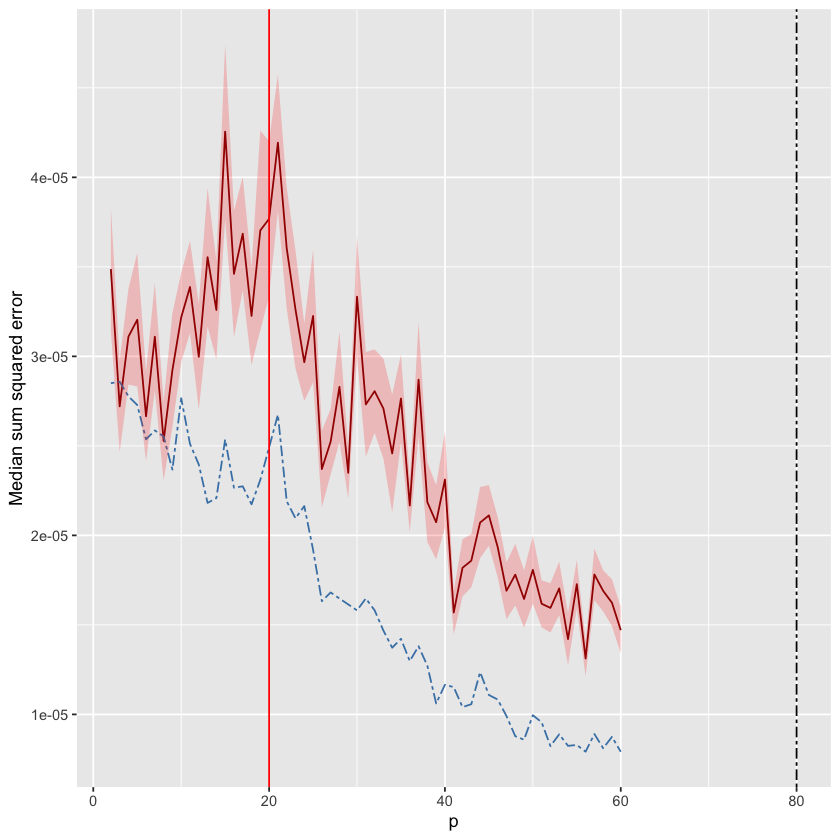

In [9]:
# Parameters
n_iter = 20
n = 80
k = 20 
s = 10
lambda = .01
degree = seq(2,60)

# Aggregated output
train_rss = matrix(data=NA,nrow=length(degree),ncol=n_iter)
test_rss = matrix(data=NA,nrow=length(degree),ncol=n_iter)

# Loop through n_iter times
for (i in 1:n_iter) {
  bv_df = bv_ridge(n,degree,k,s,lambda)
  train_rss[,i]=bv_df$train
  test_rss[,i] =bv_df$test
}

# Make a new data frame for plotting
run_df = data.frame(p=degree, train=rowMeans(train_rss), test=rowMeans(test_rss),
                    strain=rowSds(train_rss), stest=rowSds(test_rss))

# Plot
ggplot(run_df, aes(x=p)) +
  geom_line(aes(y = test), color = "darkred") +
  geom_line(aes(y = train), color="steelblue", linetype="twodash") +
  geom_vline(xintercept = n, color = "black",  linetype="twodash", size=0.5) +
  geom_vline(xintercept = k, color = "red", size=0.5) +
  geom_ribbon(aes(ymin=test-(stest/sqrt(n))*1.96, ymax=test+(stest/sqrt(n))*1.96), fill="red", alpha=0.2) +
  ylab("Median sum squared error") + xlab("p")

See what just happened there? The test error (red) peaks at $k$ and then after that it continues to fall. The training error (blue dashed) just falls as normal. 

Does this cross that uniqueness threshold of $p=n$?

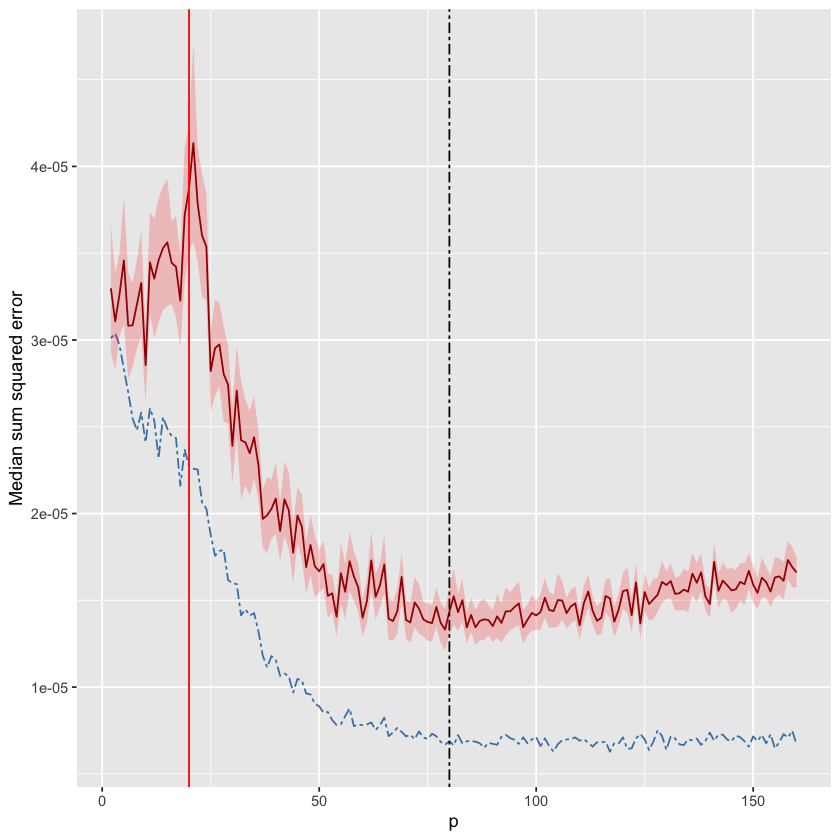

In [10]:
# Parameters
n_iter = 50
n = 80
k = 20 
s = 10
lambda = .01
degree = seq(2,2*n)

# Aggregated output
train_rss = matrix(data=NA,nrow=length(degree),ncol=n_iter)
test_rss = matrix(data=NA,nrow=length(degree),ncol=n_iter)

# Loop through n_iter times
for (i in 1:n_iter) {
  bv_df = bv_ridge(n,degree,k,s,lambda)
  train_rss[,i]=bv_df$train
  test_rss[,i] =bv_df$test
}

# Make a new data frame for plotting
run_df = data.frame(p=degree, train=rowMeans(train_rss), test=rowMeans(test_rss),
                    strain=rowSds(train_rss), stest=rowSds(test_rss))

# Plot
ggplot(run_df, aes(x=p)) +
  geom_line(aes(y = test), color = "darkred") +
  geom_line(aes(y = train), color="steelblue", linetype="twodash") +
  geom_vline(xintercept = n, color = "black",  linetype="twodash", size=0.5) +
  geom_vline(xintercept = k, color = "red", size=0.5) +
  geom_ribbon(aes(ymin=test-(stest/sqrt(n))*1.96, ymax=test+(stest/sqrt(n))*1.96), fill="red", alpha=0.2) +
  ylab("Median sum squared error") + xlab("p")

Yup. It blows right past it! So it is not a typical double descent, which usually happens after $n=p$, but it's an early double descent phenomenon.

This looks to be tied to the rank of the input data, $k$. To confirm this, let's move $k$ around and see how that bump moves.

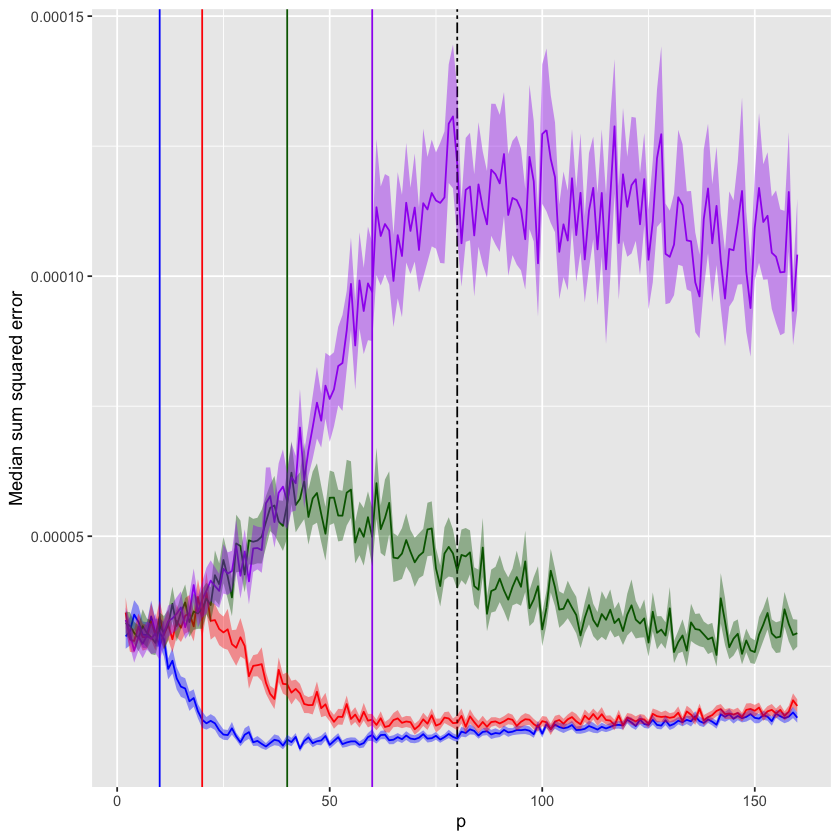

In [11]:
# Parameters
n_iter = 50
n = 80
k = 20 
s = 10
lambda = .01
degree = seq(2,n*2)

# Four k values: 10, 20, 40, 60
k10_rss = matrix(data=NA,nrow=length(degree),ncol=n_iter)
k20_rss = matrix(data=NA,nrow=length(degree),ncol=n_iter)
k40_rss = matrix(data=NA,nrow=length(degree),ncol=n_iter)
k60_rss = matrix(data=NA,nrow=length(degree),ncol=n_iter)

# Loop for n_iter iterations
for (i in 1:n_iter) {
  bv_k10 = bv_ridge(n,degree,10,s,lambda)
  k10_rss[,i]=bv_k10$test
  
  bv_k20 = bv_ridge(n,degree,20,s,lambda)
  k20_rss[,i]=bv_k20$test
  
  bv_k40 = bv_ridge(n,degree,40,s,lambda)
  k40_rss[,i]=bv_k40$test
  
  bv_k60 = bv_ridge(n,degree,60,s,lambda)
  k60_rss[,i]=bv_k60$test
  
}

# Plotting data object
run_df = data.frame(p=degree, k10=rowMeans(k10_rss), k20=rowMeans(k20_rss), 
                    k40=rowMeans(k40_rss), k60=rowMeans(k60_rss),
                    sk10=rowSds(k10_rss), sk20=rowSds(k20_rss), 
                    sk40=rowSds(k40_rss), sk60=rowSds(k60_rss))

# Pretty picture
ggplot(run_df, aes(x=p)) +
  geom_line(aes(y = k10), color="blue") +
  geom_line(aes(y = k20), color = "red") +
  geom_line(aes(y = k40), color="darkgreen") +
  geom_line(aes(y = k60), color="purple") +
  geom_vline(xintercept = n, color = "black", size=0.5, linetype="twodash") +
  geom_vline(xintercept = 10, color = "blue", size=0.5) +
  geom_vline(xintercept = 20, color = "red", size=0.5) +
  geom_vline(xintercept = 40, color = "darkgreen", size=0.5) +
  geom_vline(xintercept = 60, color = "purple", size=0.5) +  
  geom_ribbon(aes(ymin=k10-(sk10/sqrt(n))*1.96, ymax=k10+(sk10/sqrt(n))*1.96), fill="blue", alpha=0.4) +
  geom_ribbon(aes(ymin=k20-(sk20/sqrt(n))*1.96, ymax=k20+(sk20/sqrt(n))*1.96), fill="red", alpha=0.4) +
  geom_ribbon(aes(ymin=k40-(sk40/sqrt(n))*1.96, ymax=k40+(sk40/sqrt(n))*1.96), fill="darkgreen", alpha=0.4) +
  geom_ribbon(aes(ymin=k60-(sk60/sqrt(n))*1.96, ymax=k60+(sk60/sqrt(n))*1.96), fill="purple", alpha=0.4) +
  ylab("Median sum squared error") + xlab("p")


The vertical lines in the plot above show the specific $k$ values (solid) and the $p=n$ boundary (dashed).

So with $k=10$ (blue) the drop off begins around $p=10$. Same for when $k=20$ (red, our original rank). With enough time the $k=10$ and $k=20$ test error converge. 

When $k=40$ (green), the descent begins a little longer after $p=40$ and shows a slower descent, but still goes down. 

When $k=60$ (purple), which is close to the $p=n$ boundary (black dashed) and near full rank, the descent seems to disappear (it doesn't seem to descent when you go out to large $p$'s, something you can verify by extending the _degree_ array and re-running the sim).

## Lesson: 

As the rank of the matrix increases towards the $p=n$ limit, this odd drop in the test error disappears. 

---
Next let's see how this is impacted by signal to noise, $s$, holding $\lambda$ constant.

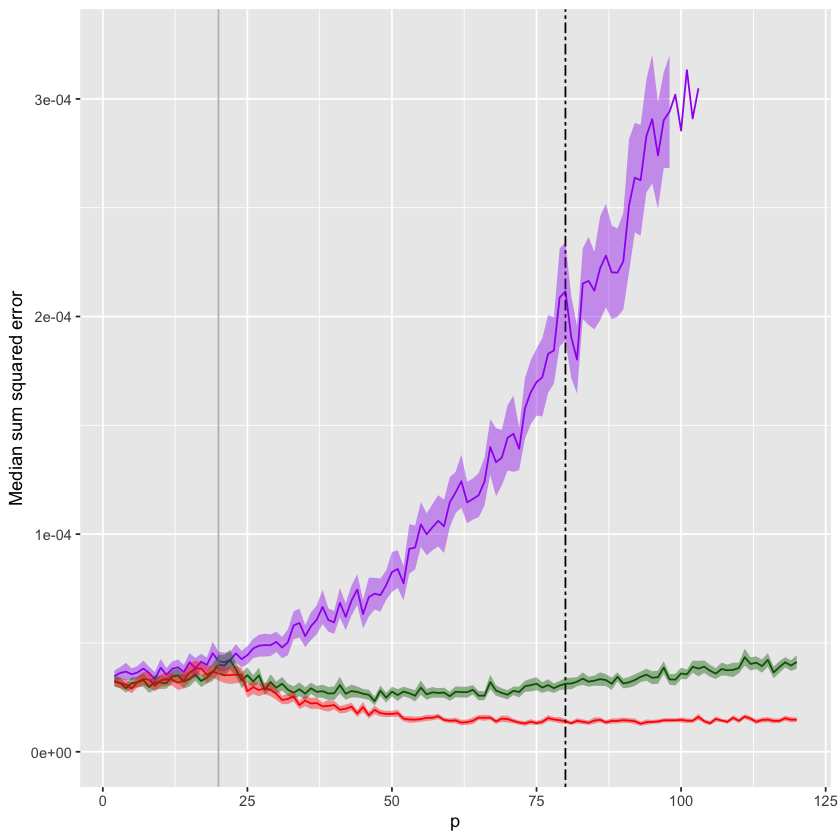

In [12]:
# Parameters
n_iter = 50
n = 80
k = 20 
lambda = .01
degree = seq(2,n*1.5)

# Three s values: 1, 5, 10
s1_rss = matrix(data=NA,nrow=length(degree),ncol=n_iter)
s5_rss = matrix(data=NA,nrow=length(degree),ncol=n_iter)
s10_rss = matrix(data=NA,nrow=length(degree),ncol=n_iter)

# Loop for n_iter iterations
for (i in 1:n_iter) {
  bv_s1 = bv_ridge(n,degree,k,1,lambda)
  s1_rss[,i]=bv_s1$test
  
  bv_s5 = bv_ridge(n,degree,k,5,lambda)
  s5_rss[,i]=bv_s5$test
  
  bv_s10 = bv_ridge(n,degree,k,10,lambda)
  s10_rss[,i]=bv_s10$test
  
}

# Data frame for plotting
run_df = data.frame(p=degree,  s1=rowMeans(s1_rss), 
                    s5=rowMeans(s5_rss), s10=rowMeans(s10_rss),
                    ss1=rowSds(s1_rss), 
                    ss5=rowSds(s5_rss), ss10=rowSds(s10_rss))

# Plot and cap y-axis for visualization
ggplot(run_df, aes(x=p)) +
  geom_line(aes(y = s1), color = "purple") +
  geom_line(aes(y = s5), color="darkgreen") +
  geom_line(aes(y = s10), color="red") +
  geom_vline(xintercept = n, color = "black", size=0.5, linetype="twodash") +
  geom_vline(xintercept = k, color = "grey", size=0.5) +
  geom_ribbon(aes(ymin=s1-(ss1/sqrt(n))*1.96, ymax=s1+(ss1/sqrt(n))*1.96), fill="purple", alpha=0.4) +
  geom_ribbon(aes(ymin=s5-(ss5/sqrt(n))*1.96, ymax=s5+(ss5/sqrt(n))*1.96), fill="darkgreen", alpha=0.4) +
  geom_ribbon(aes(ymin=s10-(ss10/sqrt(n))*1.96, ymax=s10+(ss10/sqrt(n))*1.96), fill="red", alpha=0.4) +
  ylab("Median sum squared error") + xlab("p") + ylim(0,3.25e-04)



Notice that with a low signal-to-noise ratio, $s=1$ (purple), the descent disappears altogether.

With a signal-to-noise ratio at half of our original value $s=5$ (green), the descent reappears but the test error asymptotes higher than the asymptote for our original $s=10$ (red).

As before, this happens well before the $p=n$ boundary, because $k=20$.

## Lesson:

The presence of the early descent requires a high degree of signal-to-noise in the original data set to be detected.

---

For the final test, let's see how this effect varies with $\lambda$ (which should be similar to what we see with varying $s$)

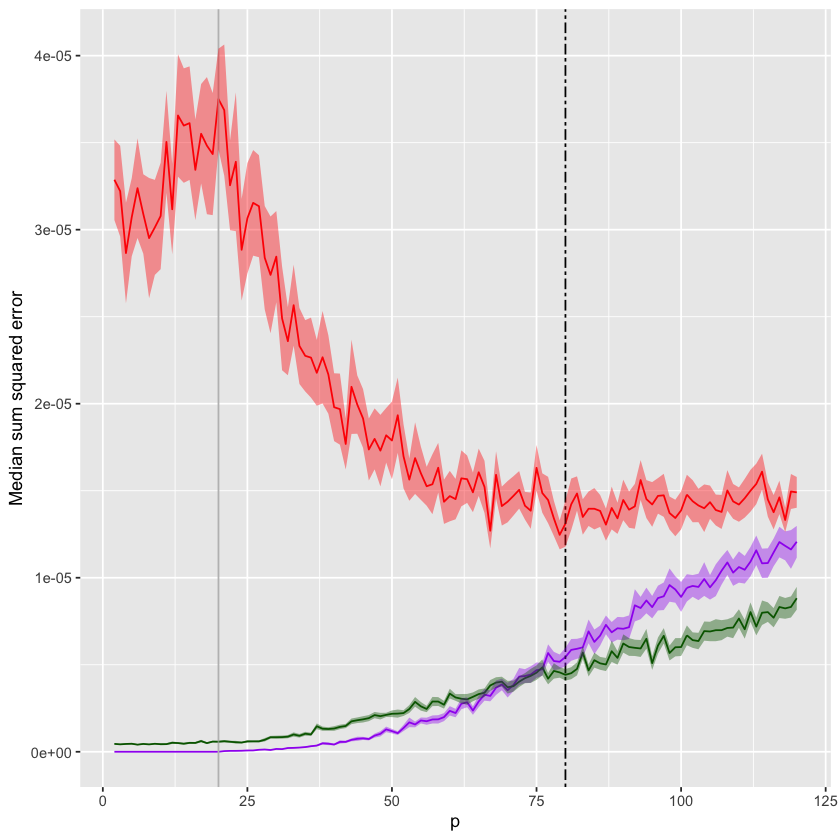

In [13]:
# Parameters
n_iter = 50
n = 80
k = 20 
s = 10
degree = seq(2,n*1.5)
lp00001_rss = matrix(data=NA,nrow=length(degree),ncol=n_iter)
lp001_rss = matrix(data=NA,nrow=length(degree),ncol=n_iter)
lp01_rss = matrix(data=NA,nrow=length(degree),ncol=n_iter)

# Loop through n_iter iterations
for (i in 1:n_iter) {
  bv_lp00001 = bv_ridge(n,degree,k,s,.00001)
  lp00001_rss[,i]=bv_lp00001$test
  
  bv_lp001 = bv_ridge(n,degree,k,s,.001)
  lp001_rss[,i]=bv_lp001$test

  bv_lp01 = bv_ridge(n,degree,k,s,.01)
  lp01_rss[,i]=bv_lp01$test
  
}

# Data frame for plotting
run_df = data.frame(p=degree,  lp00001=rowMeans(lp00001_rss), 
                    lp01=rowMeans(lp01_rss), lp001=rowMeans(lp001_rss),
                    slp00001=rowSds(lp00001_rss), 
                    slp01=rowSds(lp01_rss), slp001=rowSds(lp001_rss))

# Make pretty
ggplot(run_df, aes(x=p)) +
  geom_line(aes(y = lp00001), color = "purple") +
  geom_line(aes(y = lp001), color="darkgreen") +
  geom_line(aes(y = lp01), color="red") +
  geom_vline(xintercept = n, color = "black", size=0.5, linetype="twodash") +
  geom_vline(xintercept = k, color = "grey", size=0.5) +
  geom_ribbon(aes(ymin=lp00001-(slp00001/sqrt(n))*1.96, ymax=lp00001+(slp00001/sqrt(n))*1.96), fill="purple", alpha=0.4) +
  geom_ribbon(aes(ymin=lp001-(slp001/sqrt(n))*1.96, ymax=lp001+(slp001/sqrt(n))*1.96), fill="darkgreen", alpha=0.4) +
  geom_ribbon(aes(ymin=lp01-(slp01/sqrt(n))*1.96, ymax=lp01+(slp01/sqrt(n))*1.96), fill="red", alpha=0.4) +
  ylab("Median sum squared error") + xlab("p") 


When $\lambda = 0.01$ (red) as in our previous sims, we recover the effect. As expected.

When $\lambda = 0.001$ (green), we see a return to the more normal overparameterization effect (i.e., recovery of the bias-variance tradeoff).

When $\lambda=0.0001$ (purple), this recovery of the bias-variance effect gets stronger. 

Notice how the test errors with weaker sparsity parameters are much lower than the test error with a stronger sparsity parameter. This is interesting and I don't know what to make of it.

In order to really expand on this effect, let's run a simulation where we just use 2 model complexities: $p=k$ and $p=n$. Taking the difference in residual sums of squares $p_n-p_k$ will give us the "direction" of the descent. By running across a range of lambdas, we can plot when we go from test error increasing to test error decreasing with larger $p$'s.

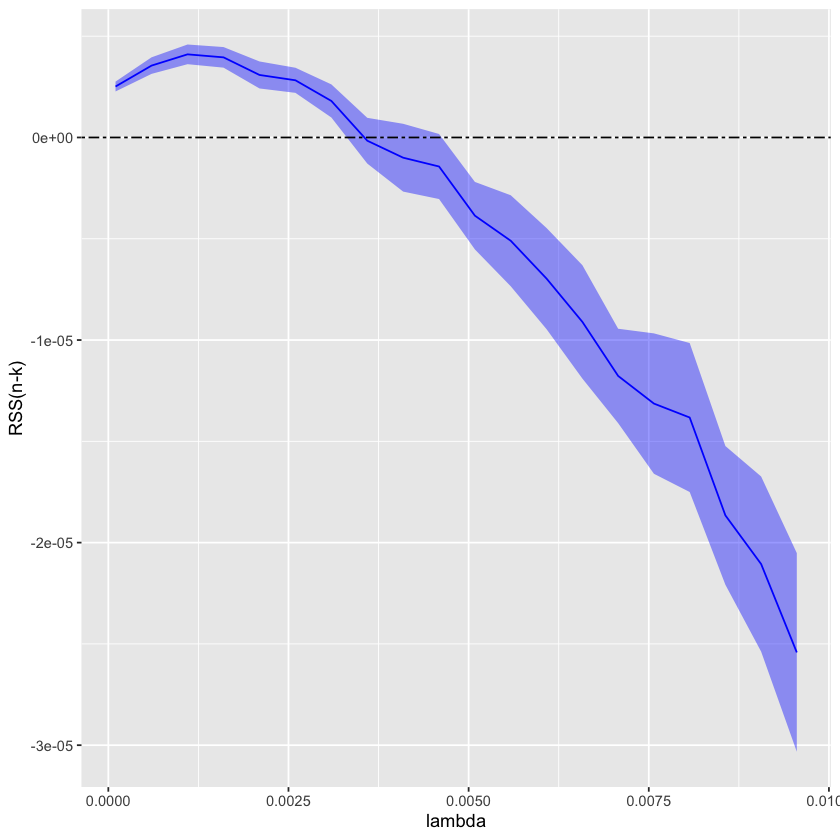

In [14]:
#Parameters
lambda_list = log(seq(1.0001,1.01005,by=0.0005))
n = 80
k = 20 
s = 10
n_iter = 50
diff_rss = matrix(data=NA,nrow=n_iter,ncol=length(lambda_list))

# Loop through n_iter iterations
for (l in 1:length(lambda_list)) {
 
   for (i in 1:n_iter){
     bv_k = bv_ridge(n,k,k,s,lambda_list[l])
     bv_n = bv_ridge(n,n,k,s,lambda_list[l])
     
     diff_rss[i,l]= bv_n$test[1] - bv_k$test[1]
       
    }
}

# Data frame for plotting
run_df = data.frame(l=lambda_list, dr=colMeans(diff_rss), sdr = colSds(diff_rss))

# Plot
ggplot(run_df, aes(x=l)) +
  geom_line(aes(y = dr), color = "blue") +
  geom_ribbon(aes(ymin=dr-(sdr/sqrt(n_iter))*1.96, ymax=dr+(sdr/sqrt(n_iter))*1.96), fill="blue", alpha=0.4)+
  geom_hline(yintercept = 0, color = "black", size=0.5, linetype="twodash") +
  ylab("RSS(n-k)") + xlab("lambda")   

## Conclusion:

When inputs are low-rank and regularlization is applied, a variant of a "double descent" emerges, with a peak test error at ~$k$. 

- As the rank $k$ of the inputs $X$ approaches $n$ the effect attenuates.
- The effect is only present when $X$ has a high signal-to-noise $s$.
- As the sparsity penalty $\lambda$ is reduced, the effect attenuates; **however** the overal test error is lower with lower $\lambda$.

